In [11]:
import re
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('seaborn-whitegrid')

# Read in file with tweets, drop rows with NaN
tweets = pd.read_csv('../tweets/tweets_clean.csv',
                     header=0,
                     parse_dates=['date'])
tweets.dropna(subset=['lemmas'], inplace=True)
tweets.reset_index(drop=True, inplace=True)

In [4]:
def clean_text(text):
    """
    Mini-preprocess function to remove links and split 'not' contractions

    :param text: Raw text
    :return: Processed text
    """
    # Remove URLs
    www_exp = r'www.[^ ]+'
    http_exp = r'http?s?[^\s]+'
    clean = re.sub('|'.join((www_exp, http_exp)), '', text)

    # Split 'not' contractions
    contraction_dict = {'can\'t': 'can not', 'won\'t': 'will not',
                        'isn\'t': 'is not', 'aren\'t': 'are not',
                        'wasn\'t': 'was not', 'weren\'t': 'were not',
                        'haven\'t': 'have not', 'hasn\'t': 'has not',
                        'wouldn\'t': 'would not', 'don\'t': 'do not',
                        'doesn\'t': 'does not', 'didn\'t': 'did not',
                        'couldn\'t': 'could not', 'shouldn\'t': 'should not',
                        'mightn\'t': 'might not', 'mustn\'t': 'must not',
                        'had\'t': 'had not'}
    contraction_exp = re.compile(r'\b(' + '|'.join(contraction_dict.keys()) + r')\b')
    clean = contraction_exp.sub(lambda x: contraction_dict[x.group()], clean)

    return clean

In [5]:
def sentiment(x):
    """
    Function to return the polarity and subjectivity of Textblob sentiment analysis

    :param x: Text string
    :return: Pandas Series with the polarity and subjectivity of text sentiment
    """
    blob = TextBlob(x).sentiment
    return pd.Series({'polarity': blob.polarity,
                      'subjectivity': blob.subjectivity})

In [6]:
print('Removing links from tweet text')
tweets['text'] = tweets.text.apply(clean_text)

print('Calculating sentiment polarity and subjectivity')
sentiment_df = tweets.text.apply(sentiment)

sentiment_df.to_csv('../results_csv/tweet_sentiments.csv', index=False)

Removing links from tweet text
Calculating sentiment polarity and subjectivity


In [13]:
sentiment_df = pd.read_csv('../results_csv/tweet_sentiments.csv', header=0)
sentiment_df.set_index(tweets['date'], inplace=True)

# Create a categorical column that separates tweets into positive, neutral, or negative categories by polarity
sentiment_df['polarity_cat'] = np.where(sentiment_df['polarity'] > 0.1, 'Positive',
                                        np.where(sentiment_df['polarity'] < -0.1, 'Negative', 'Neutral'))

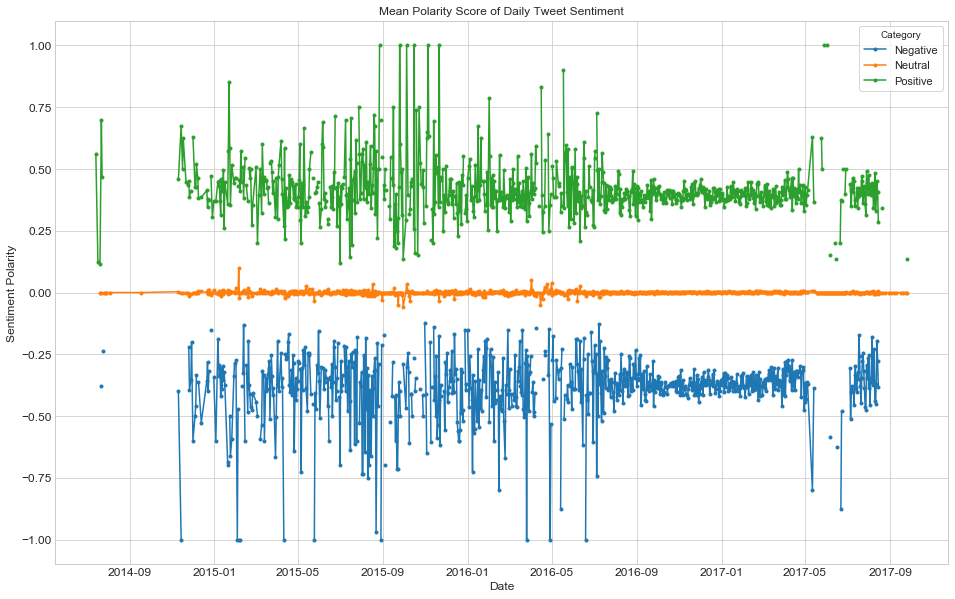

In [17]:
# Group tweets by date and sentiment category and calculate the mean polarity score
daily_sentiment = sentiment_df.groupby([sentiment_df.index.date,
                                        sentiment_df['polarity_cat']]).mean().unstack(level=1)

# Plot the daily mean polarity of tweets by sentiment category
fig1 = daily_sentiment['polarity'].plot(figsize=(16, 10),
                                        use_index=True,
                                        style='.-',
                                        title='Mean Polarity Score of Daily Tweet Sentiment',
                                        fontsize=12)
fig1.legend(title='Category', fontsize=11, frameon=True)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)

plt.show()

In [15]:
# Group tweets by month and sentiment category and calculate the mean polarity score
monthly_sentiment = sentiment_df.groupby([sentiment_df.index.year, sentiment_df.index.month,
                                          sentiment_df['polarity_cat']]).mean().unstack(level=2)
monthly_sentiment.index.rename(['year', 'month'], inplace=True)

# Collapse index back into a single date
monthly_sentiment.reset_index(inplace=True)
monthly_sentiment.set_index(pd.to_datetime(dict(year=monthly_sentiment.year,
                                                month=monthly_sentiment.month,
                                                day=[1] * len(monthly_sentiment))))
monthly_sentiment.drop(['year', 'month'], axis=1, inplace=True)

C:\Users\jmelt\AppData\Local\Programs\Python\Python36-32\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


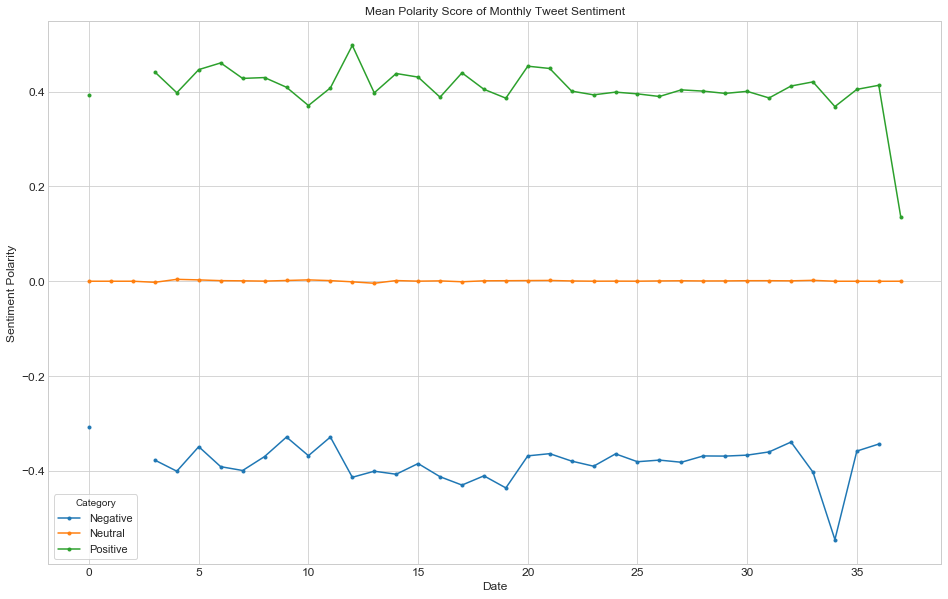

In [18]:
# Plot the monthly mean polarity of tweets by sentiment category
fig1 = monthly_sentiment['polarity'].plot(figsize=(16, 10),
                                          use_index=True,
                                          style='.-',
                                          title='Mean Polarity Score of Monthly Tweet Sentiment',
                                          fontsize=12)
fig1.legend(title='Category', loc='lower left', frameon=True, fontsize=11)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)

plt.show()

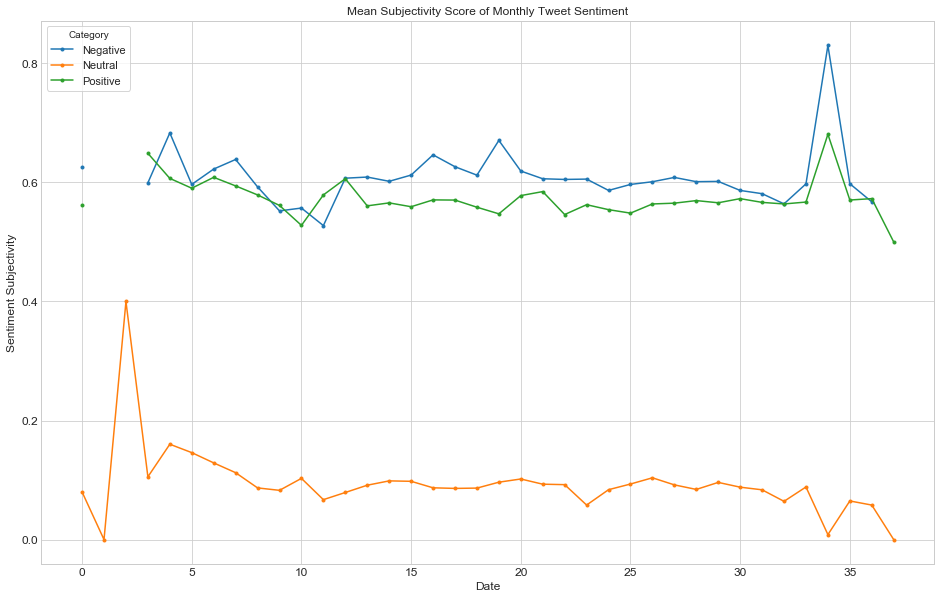

In [20]:
# Plot the monthly mean subjectivity of tweets by sentiment category
fig2 = monthly_sentiment['subjectivity'].plot(figsize=(16, 10),
                                              use_index=True,
                                              style='.-',
                                              title='Mean Subjectivity Score of Monthly Tweet Sentiment',
                                              fontsize=12)
fig2.legend(title='Category', loc='upper left', frameon=True, fontsize=11)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Subjectivity', fontsize=12)

plt.show()

In [21]:
# Read in file containing the topic probabilities for each tweet
topics = pd.read_csv('../results_csv/topics_per_doc_LDA.csv', header=0)
topics.rename(columns={'dominant_topic': 'topic'}, inplace=True)

# Create new df with the dominant topic and sentiment for each tweet
# Set tweets' dates as df index
sentiment_df.reset_index(drop=True, inplace=True)  # Reset index for concatenation
topic_sentiment = pd.concat([topics['topic'], sentiment_df], axis=1)
topic_sentiment.set_index(tweets['date'], inplace=True)

In [22]:
# Group tweets by their topic and sentiment category
# Count the number of tweets, the mean and variance of the sentiment polarity
topic_sentiment = topic_sentiment.groupby([topic_sentiment['topic'],
                                           topic_sentiment['polarity_cat']]).agg(['count', 'mean', 'var'])['polarity']

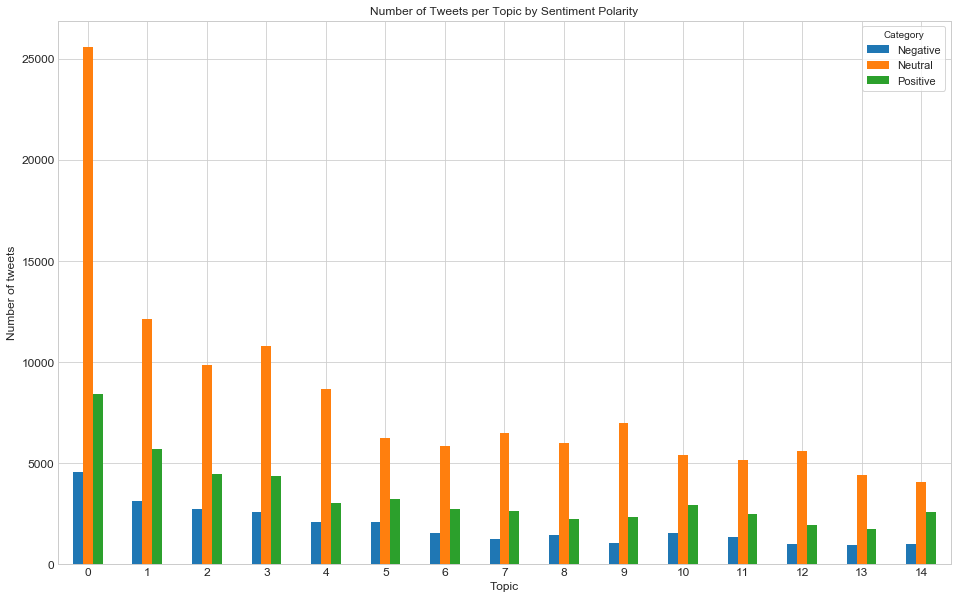

In [23]:
fig = topic_sentiment.unstack()['count'].plot(kind='bar',
                                              figsize=(16, 10),
                                              rot=0,
                                              title='Number of Tweets per Topic by Sentiment Polarity',
                                              fontsize=12)
fig.legend(title='Category', frameon=True, fontsize=11)
fig.set_xlabel('Topic', fontsize=12)
fig.set_ylabel('Number of tweets', fontsize=12)

plt.show()

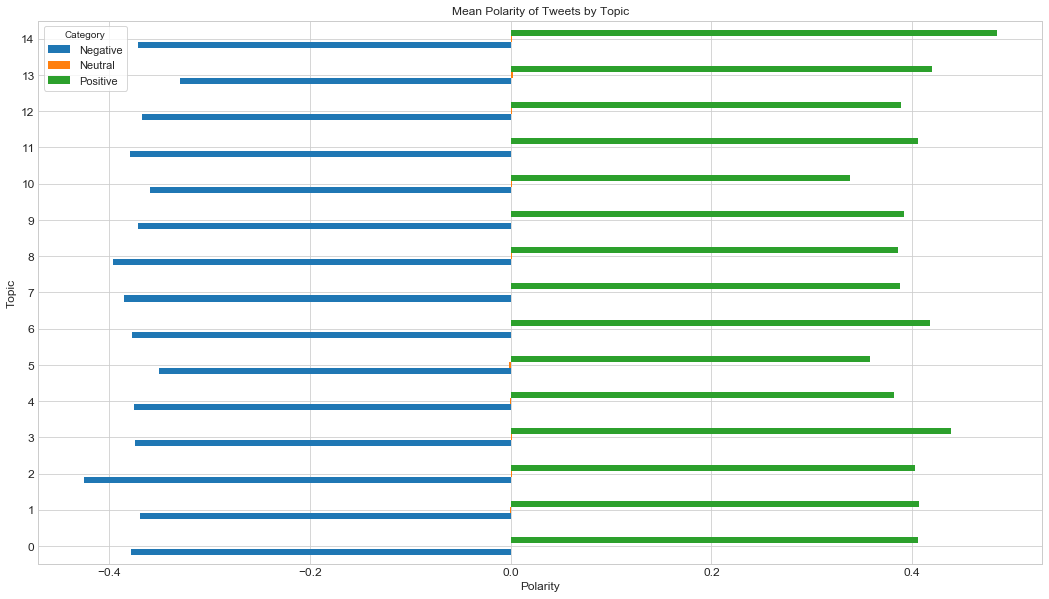

In [25]:
fig = topic_sentiment.unstack()['mean'].plot(kind='barh',
                                             figsize=(18, 10),
                                             rot=0,
                                             title='Mean Polarity of Tweets by Topic',
                                             fontsize=12)
fig.legend(title='Category', frameon=True, fontsize=11)
fig.set_xlabel('Polarity', fontsize=12)
fig.set_ylabel('Topic', fontsize=12)

plt.show()